In [26]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
warnings.filterwarnings("ignore")
import ot
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

In [27]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
    0.1 + i*0.05*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

# def data_scaled(N, m, scale, seed):
#     np.random.seed(seed)
#     R = np.vstack([np.random.normal(
#     i*0.03*scale, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
#     return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

m = 30
data = data_modes(600,m,[1,2,3,4,5],seed = 15)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = 8 + scene*0.5

In [28]:
def loss(y,tau,x,p,alpha, data,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    sums += torch.sum(torch.maximum(torch.maximum(-data@x + p*tau - y- alpha,(-1-5*p)*data@x - 4*p*tau - y- alpha),torch.tensor(0.,requires_grad = True)))
    totsum += torch.sum(torch.where(torch.maximum(torch.maximum(-data@x + p*tau - y- alpha,(-1-5*p)*data@x - 4*p*tau - y- alpha),torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return y + torch.tensor(l)*(sums - torch.tensor(target)), torch.mean(-data@x)+p*torch.mean(tau + 5*torch.maximum(-data@x-tau,torch.tensor(0))), totsum/Nsample, sums.detach().numpy()


In [34]:
data = data_modes(600,m,[1,2,3,4,5],seed = 5)
u = lropt.UncertainParameter(m,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x = cp.Variable(m)
tau = cp.Variable()
y = cp.Variable()
p = cp.Parameter()
p.value = scenarios[0][0]
objective = cp.Minimize(y)
constraints = [p >= 0]
constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
constraints += [cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)

target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
# init = np.eye(m)
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.00001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.00001,batch_percentage = 0.8)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

In [35]:
# Grid search epsilon
np.linspace(0.001,10, 200)
result4 = prob.grid(epslst = np.logspace(-2,2,100), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.logspace(-2,2,100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

In [36]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), switch = (30,30), logscale = True, legend = False, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2
    switch1,switch2 = switch

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax.fill(
                np.append(np.append(np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:switch1],np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[switch1:end1]), np.append(np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[switch1:end1][::-1],np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:switch1][::-1])),np.append(np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:switch1],np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[switch1:end1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[switch1:end1][::-1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:switch1][::-1])), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")

    ax.fill(
                np.append(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:switch2],np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[switch2:end2]), np.append(np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[switch2:end2][::-1],np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:switch2][::-1])),np.append(np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:switch2],np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[switch2:end2]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[switch2:end2][::-1],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:switch2][::-1])), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    ax.set_ylabel("Objective value")
    ax.set_yticks(ticks = [-5,-15])

    # ax.set_yticks(ticks = [-2e1,0,2e1])
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    ax1.set_yticks(ticks = [-5,-15])
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if zoom:
        axins = zoomed_inset_axes(ax2, 6, loc="upper center")
        axins.set_xlim(-0.005, 0.1)
        axins.set_ylim(-0.001,0.035)
        axins.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue")
        axins.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange",alpha = 0.8)
        axins.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
        axins.set_xticks(ticks=[])
        axins.set_yticks(ticks=[])
        mark_inset(ax2, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    if legend:
        ax2.legend(bbox_to_anchor=(-1.8, -0.6, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.subplots_adjust(left=0.1)
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

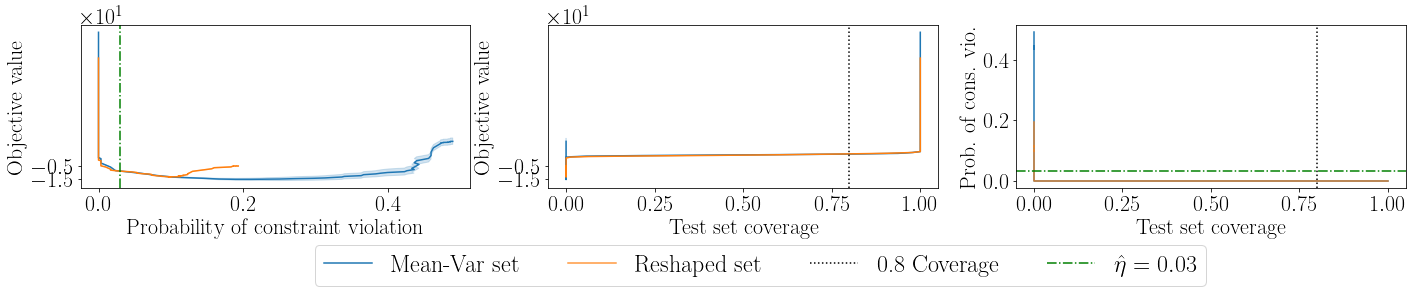

In [37]:
plot_coverage_all(dfgrid,dfgrid2,None, "Port30",ind_1=(0,400),ind_2=(0,400), logscale = False, switch = (80,40),legend = True)

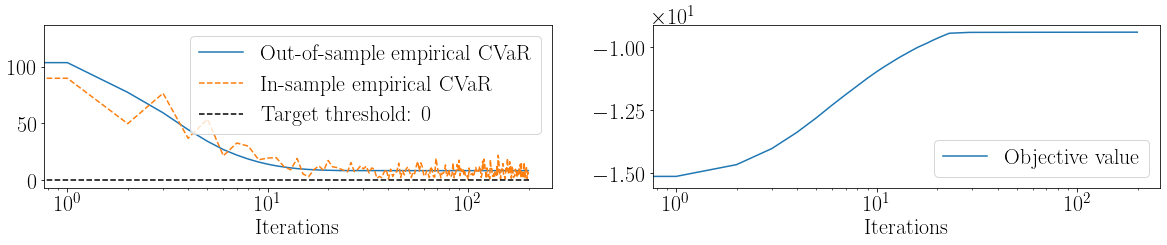

In [38]:
plot_iters(df1,"Port", steps = 800,logscale = 1)

In [10]:
dfgrid.to_pickle("dfst_30.pkl")
dfgrid2.to_pickle("dfre_30.pkl")

In [33]:
ind_1 = {0:(0,400),1:(0,400),2:(0,400)}

In [7]:
def plot_combined(dfs,dfr,title,ind_1 = {0:(0,400),1:(0,400),2:(0,400)}, ind_2 = {0:(0,400),1:(0,400),2:(0,400)}, switch = {0:(30,30),1:(30,30),2:(30,30)}, logscale = True, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    

    fig, ax = plt.subplots(2, 3, figsize=(18, 6))
    
    for i in range(3):
        df_standard = dfs[i]
        df_reshape = dfr[i]
        beg1,end1 = ind_1[i]
        beg2,end2 = ind_2[i]
        switch1,switch2 = switch[i]
        ax[0,i].plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
        ax[0,i].fill(
                np.append(np.append(np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:switch1],np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[switch1:end1]), np.append(np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[switch1:end1][::-1],np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:switch1][::-1])),np.append(np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:switch1],np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[switch1:end1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[switch1:end1][::-1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:switch1][::-1])), color="tab:blue", alpha=0.2)

        ax[0,i].plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
        ax[0,i].fill(
                np.append(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:switch2],np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[switch2:end2]), np.append(np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[switch2:end2][::-1],np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:switch2][::-1])),np.append(np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:switch2],np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[switch2:end2]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[switch2:end2][::-1],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:switch2][::-1])), color="tab:orange", alpha=0.2)
        # # ax[0,0].set_xlabel("Probability of constraint violation")
        ax[0,i].axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
        ax[0,i].ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
        if i == 0:
            ax[0,i].set_title("$m=10$")
        elif i ==1:
            ax[0,i].set_title("$m=15$")
        else:
            ax[0,i].set_title("$m=30$")
        # ax.legend()

        ax[1,i].plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

        ax[1,i].plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)

        ax[1,i].axvline(x = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
        ax[1,i].axhline(y = 0.8,color = "black",linestyle = ":", label = "0.8 Coverage")
        ax[1,i].set_xlabel("Probability of constraint violation")
        
        if i == 0:
            ax[1,i].set_ylabel("Test set coverage")
            ax[0,i].set_ylabel("Objective value")

        if zoom:
            axins = zoomed_inset_axes(ax[1,i], 5, loc="upper center")
            axins.set_ylim(0.27, 0.45)
            axins.set_xlim(0.005,0.070)
            axins.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1],np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], color="tab:blue")
            axins.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], color="tab:orange",alpha = 0.8)
            axins.axvline(x = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
            axins.set_xticks(ticks=[])
            axins.set_yticks(ticks=[])
            mark_inset(ax[1,i], axins, loc1=3, loc2=4, fc="none", ec="0.5")
    
    ax[1,0].legend(bbox_to_anchor=(0.2, -0.8, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    # plt.subplots_adjust(left=0.1)
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

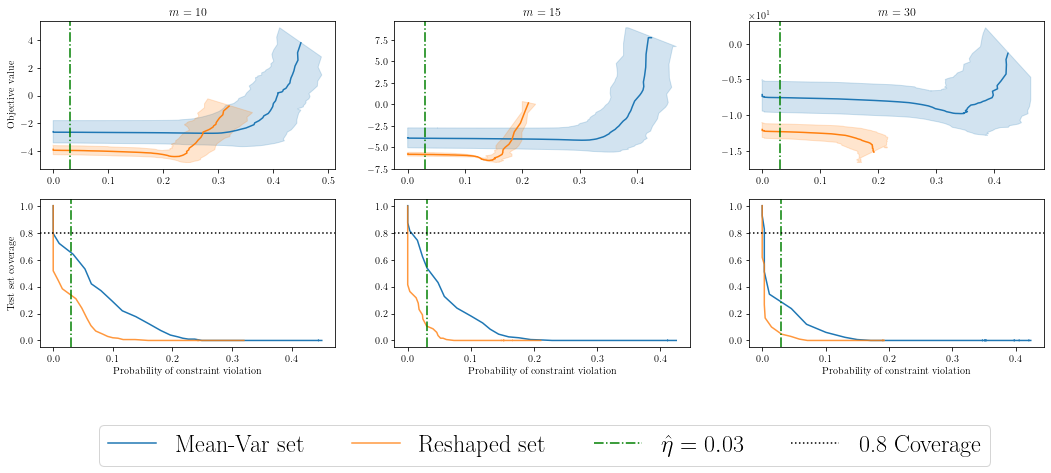

In [8]:
dfs = {}
dfs[0] = pd.read_pickle("dfst_10.pkl")
dfs[1] = pd.read_pickle("dfst_15.pkl")
dfs[2] = pd.read_pickle("dfst_30.pkl")

dfr = {}
dfr[0] = pd.read_pickle("dfre_10.pkl")
dfr[1] = pd.read_pickle("dfre_15.pkl")
dfr[2] = pd.read_pickle("dfre_30.pkl")


plot_combined(dfs,dfr,"portfolio",ind_1 = {0:(15,400),1:(20,400),2:(20,400)}, ind_2 = {0:(15,400),1:(18,400),2:(40,400)}, switch = {0:(80,80),1:(80,80),2:(80,30)}, logscale = True, zoom = False)

In [192]:
mval = np.mean(np.vstack(dfgrid["Test_val"]),axis = 1)[-1]
rval = np.mean(np.vstack(dfgrid2["Test_val"]),axis = 1)[-1]
(rval - mval)/mval

0.6849312107858369

In [88]:
epslst = np.linspace(0.001, 3, 100)
prob_list = np.array([0.,0.001,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)-i).argmin())
st_eps = np.linspace(0.01, 3, 100)[inds_standard[0]]
re_eps = np.linspace(0.01, 3, 100)[inds_reshaped[0]]
st_eps, re_eps

(0.6442424242424243, 1.2180808080808083)

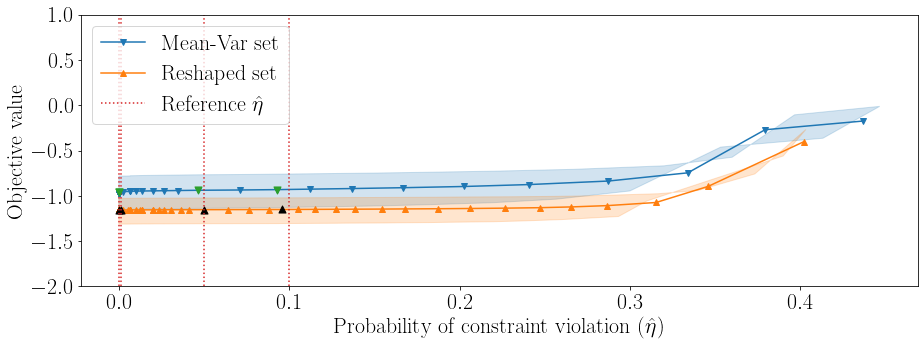

In [90]:
# eps_list = np.linspace(0.01, 2.98, 40)
# inds = [13,8,6,5]
# inds = [20,13,10,7]
eps_list = np.linspace(0.001, 3, 100)

plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Violations']),axis = 1)[:], np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[:], color="tab:blue", label=r"Mean-Var set", marker = "v",zorder=0)
plt.fill(np.append(np.quantile(np.vstack(dfgrid['Violations']),0.25,axis = 1),np.quantile(np.vstack(dfgrid['Violations']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid['Test_val']),0.25,axis = 1),np.quantile(np.vstack(dfgrid['Test_val']),0.75,axis = 1)[::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(dfgrid['Violations']),axis = 1)[inds_standard[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds_standard[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    # plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds_standard[ind]],2)), # this is the text
    #               (np.mean(np.vstack(dfgrid['Violations']),axis = 1)[inds_standard[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds_standard[ind]]), # these are the coordinates to position the label
    #               textcoords="offset points", # how to position the text
    #               xytext=(5,3), # distance from text to points (x,y)
    #               ha='left',color="tab:green",fontsize=15) 

plt.plot(np.mean(np.vstack(dfgrid2['Violations']),axis = 1),np.mean(np.vstack(dfgrid2['Test_val']),axis = 1), color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
plt.fill(np.append(np.quantile(np.vstack(dfgrid2['Violations']),0.25,axis = 1),np.quantile(np.vstack(dfgrid2['Violations']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid2['Test_val']),0.25,axis = 1),np.quantile(np.vstack(dfgrid2['Test_val']),0.75,axis = 1)[::-1]), color="tab:orange", alpha=0.2)
for ind in [0,2,1,3]:
    plt.scatter(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)[inds_reshaped[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds_reshaped[ind]], color="black", s = 50, marker = "^")
    # plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds_reshaped[ind]],2)), # this is the text
    #               (np.mean(np.vstack(dfgrid2['Violations']),axis = 1)[inds_reshaped[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds_reshaped[ind]]), # these are the coordinates to position the label
    #               textcoords="offset points", # how to position the text
    #               xytext=(5,1), # distance from text to points (x,y)
    #               ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
#plt.xscale("log")
plt.ylim([-2,1])
plt.vlines(ymin = -2, ymax= 1, x = prob_list[0], linestyles=":", color = "tab:red", label = "Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin = -2, ymax= 1, x = i, linestyles=":", color = "tab:red")

plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves_orig.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [92]:
x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(m,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_standard[ind]])*init, b = (1/eps_list[inds_standard[ind]])*init_bval))
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[0][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x.value, tau.value

        t_base[ind][scene] = y.value

        u = lropt.UncertainParameter(m,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_reshaped[ind]])*A_fin, b = (1/eps_list[inds_reshaped[ind]])*b_fin))
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[0][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_learned[ind][scene] = x.value, tau.value

        t_learned[ind][scene] = y.value
        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[1.50463243, 0.50444393],
        [0.5340397 , 1.53383756]]),
 array([-0.52545184, -0.67693849]),
 array([[1., 0.],
        [0., 1.]]),
 array([-0.25495436, -0.39015537]))

In [95]:
K =1
n = 2
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(num_scenarios):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds_standard[ind]])*init_bval)
            for scene in range(num_scenarios):
                g_level_learned[ind][scene][i,j] = np.maximum(scenarios[scene][0]* x_opt_learned[ind][scene][1] - x_opt_learned[ind][scene][0]@ u_vec, -4*scenarios[scene][0]*x_opt_learned[ind][scene][1]+ (-1-5*scenarios[scene][0])*x_opt_learned[ind][scene][0]@ u_vec) - t_learned[ind][scene]
                g_level_base[ind][scene][i,j] = np.maximum(scenarios[scene][0]* x_opt_base[ind][scene][1] - x_opt_base[ind][scene][0]@ u_vec, -4*scenarios[scene][0]*x_opt_base[ind][scene][1]+ (-1-5*scenarios[scene][0])*x_opt_base[ind][scene][0]@ u_vec) - t_base[ind][scene]

In [96]:

def plot_contours_line(x,y,set, g_level,prob_list, num_scenarios,train, title, standard = True):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]

    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        for scene in range(num_scenarios):
            axis.contour(x,y,g_level[cur_ind][scene],[0], colors = ["tab:purple"],alpha = 1,linestyles = ["-"])
        axis.scatter(train[:,0],train[:,1], color = "white",edgecolor = "black")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(1):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize = 30)
    plt.savefig(title+"_"+ post + ".pdf", bbox_inches='tight')


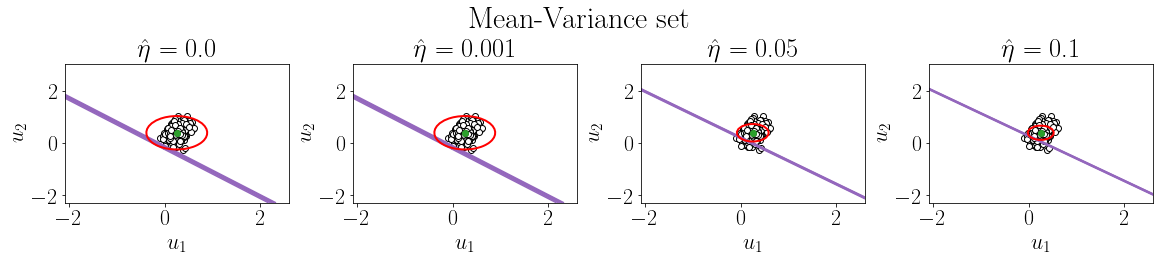

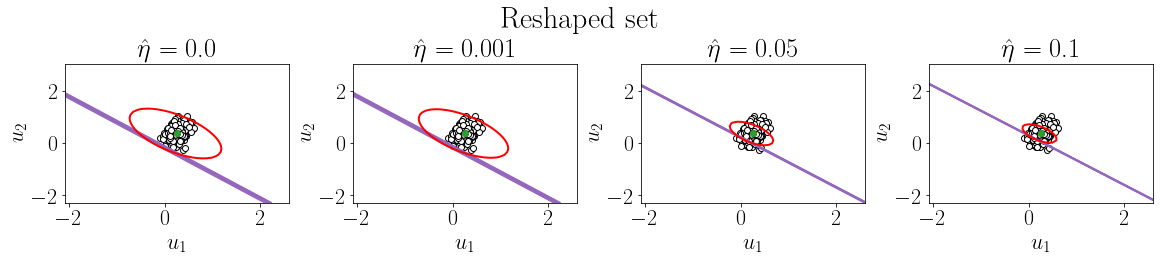

In [97]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,num_scenarios,train, "port_intro",standard = True) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,num_scenarios,train, "port_intro",standard = False)

In [65]:
m = 30
dists = []
for i in range(20): 
  data = data_modes(600,m,[1,2,3,4,5],seed = i)
  train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
  M = ot.dist(test,train, metric='euclidean')
  dists.append(ot.emd2(a = [], b= [], M=M))
np.mean(dists)

6.963227608230312

In [66]:
def wass_dist(train, test, epsilon):
  ind = 0
  for i in test:
      for j in train:
          if np.linalg.norm(i - j,2) <= epsilon:
             ind += 1
             break
  return ind/(np.shape(train)[0])

In [67]:
wassdists = []
for i in range(20): 
  data = data_modes(600,m,[1,2,3,4,5],seed = i)
  train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
  wassdists.append(wass_dist(train, test,3.36))
np.mean(wassdists)

0.0

In [71]:
mro(train,test,K=300, rho = 3.36)

(array([0.02333333, 0.02333333, 0.02333333, 0.02333333, 0.02333333]),
 array([0.05, 0.05, 0.05, 0.05, 0.05]),
 array([-10.59627911, -11.07394934, -11.55201804, -12.03042138,
        -12.50911194]),
 array([0.16641183, 0.1639325 , 0.16743221, 0.16779329, 0.19132308]))

In [390]:
reshaped_cvar, x_re = cvar_table(A_fin, b_fin, dfgrid2,test,train,0.03, eps = 0)
standard_cvar, x_st = cvar_table(init, init_bval, dfgrid,test,train,0.25, eps = 0)

In [377]:
make_table(A_fin, b_fin, dfgrid2,test,train,0.03, eps = 0)

array([[-1.02373836e+01,  2.66666673e-02,  3.33333351e-02,
         1.83333333e-01,  2.26666667e-01,  2.24545800e-03],
       [-1.06936117e+01,  2.66666673e-02,  3.33333351e-02,
         1.83333333e-01,  2.26666667e-01,  2.13975000e-03],
       [-1.11498838e+01,  2.66666673e-02,  3.33333351e-02,
         1.83333333e-01,  2.26666667e-01,  2.09554200e-03],
       [-1.16061921e+01,  2.66666673e-02,  3.33333351e-02,
         1.83333333e-01,  2.26666667e-01,  2.15904200e-03],
       [-1.20625356e+01,  2.66666673e-02,  3.33333351e-02,
         1.83333333e-01,  2.26666667e-01,  2.19416600e-03]])

In [381]:
make_table(init, init_bval, dfgrid,test,train,0.025, eps = 0)

array([[-4.65688133e+00,  2.33333334e-02,  3.66666652e-02,
         4.16666667e-01,  3.76666667e-01,  7.34708000e-04],
       [-4.78134409e+00,  2.33333334e-02,  3.66666652e-02,
         4.16666667e-01,  3.76666667e-01,  8.26625000e-04],
       [-4.90590503e+00,  2.33333334e-02,  3.66666652e-02,
         4.16666667e-01,  3.76666667e-01,  7.87667000e-04],
       [-5.03055224e+00,  2.33333334e-02,  3.66666652e-02,
         4.16666667e-01,  3.76666667e-01,  7.57292000e-04],
       [-5.15527381e+00,  2.33333334e-02,  3.66666652e-02,
         4.16666667e-01,  3.76666667e-01,  7.83083000e-04]])

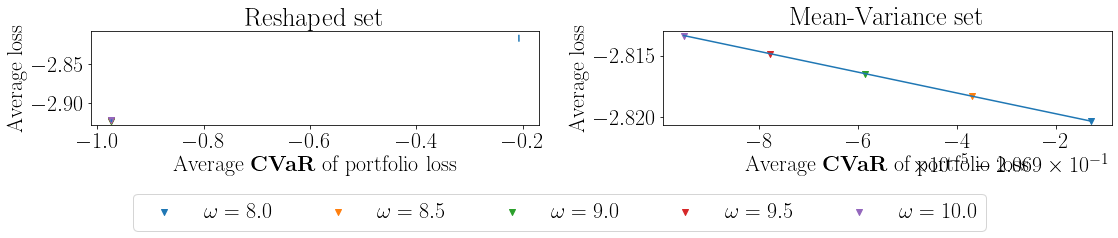

In [395]:
plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))
ax1.plot(reshaped_cvar[:,1], reshaped_cvar[:,0], color = "tab:blue")
ax1.plot(standard_cvar[:,1], standard_cvar[:,0])
for scene in range(num_scenarios):
    ax1.scatter(reshaped_cvar[scene][1], reshaped_cvar[scene][0], marker = "v", label = r'$\omega = {}$'.format(scene*0.5+8))
ax1.set_title("Reshaped set")
ax1.set_ylabel("Average loss")
ax1.set_xlabel(r"Average $\textbf{CVaR}$ of portfolio loss")
fig.legend(bbox_to_anchor=(0.5,-0.06,0,0), loc="center",
                 borderaxespad=0, ncol=5)
ax2.plot(standard_cvar[:,1], standard_cvar[:,0])
for scene in range(num_scenarios):
    ax2.scatter(standard_cvar[scene][1], standard_cvar[scene][0], marker = "v")
ax2.set_ylabel("Average loss")
ax2.set_title("Mean-Variance set")
ax2.set_xlabel(r"Average $\textbf{CVaR}$ of portfolio loss")
plt.tight_layout()
plt.savefig("port_cvar_curves.pdf",bbox_inches='tight')
plt.show()

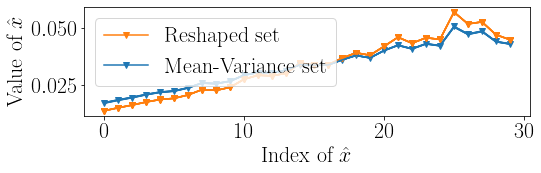

In [396]:
plt.figure(figsize=(8, 2))
plt.plot(x_re[0], color = "tab:orange", label = "Reshaped set", marker = "v")
plt.plot(x_st[0], color = "tab:blue",label = "Mean-Variance set", marker = "v")
for scene in range(1,5):
  plt.plot(x_re[scene], color = "tab:orange", marker = "v")
  plt.plot(x_st[scene], color = "tab:blue")
plt.ylabel("Value of $\hat{x}$")
plt.xlabel("Index of $\hat{x}$")
plt.legend()
plt.savefig("port_xvals.pdf", bbox_inches='tight')
plt.show()

In [29]:
eps = 0
value = 0.026
result_A = init
result_b = init_bval
if eps:
  r_eps = 1
else:
  r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
u = lropt.UncertainParameter(m,
                            uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                            rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
# Formulate the Robust Problem
x = cp.Variable(m)
tau = cp.Variable()
y = cp.Variable()
p = cp.Parameter()
p.value = scenarios[scene][0]
objective = cp.Minimize(y)
constraints = [p >= 0]
constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
constraints += [cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)
newprob = prob.dualize_constraints()
newprob.solve()

8.0700984149021

In [68]:

def eval(y,tau,x,p,data,l=10000,quantile = 0.95, target = -0.1):
    y = torch.tensor(y)
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)
    Nsample = data.shape[0]
    totsum = torch.sum(torch.where(torch.maximum(torch.maximum(-data@x + p*tau - y,(-1-5*p)*data@x - 4*p*tau - y),torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))/Nsample
    return totsum


def ret_cvar(y,tau,x,p,data):
    y = torch.tensor(y)
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)    
    return torch.mean(-data@x), torch.mean(tau + 5*torch.maximum(-data@x-tau,torch.tensor(0)))

def cvar_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,2))
    xvals = np.zeros((num_scenarios,m))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        ret, cvar = ret_cvar(y.value,tau.value,x.value,p.value,test)
        trial1[scene,0] = ret.item()
        trial1[scene,1] = cvar.item()
        xvals[scene] = x.value
    return trial1, xvals

def make_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,6))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()

        coverage = 0
        for datind in range(test.shape[0]):
            coverage += np.where(np.linalg.norm((1/r_eps)*result_A@test[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )
        coverage_train = 0
        for datind in range(train.shape[0]):
            coverage_train += np.where(np.linalg.norm((1/r_eps)*result_A@train[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )

        trial1[scene,0] = np.mean(-test@x.value)+ p.value*np.mean(tau.value + 5*np.maximum(-test@x.value-tau.value,0))
        trial1[scene,1] = eval(y.value,tau.value,x.value,p.value,test).item()
        trial1[scene,2] = eval(y.value,tau.value,x.value,p.value,train).item()
        trial1[scene,3] = coverage/test.shape[0]
        trial1[scene,4] = coverage_train/train.shape[0]
        trial1[scene,5] = newprob.solver_stats.solve_time
        # trial1[scene,6] = np.linalg.det(sc.linalg.inv((1/r_eps)*result_A@((1/r_eps)*result_A)))**0.5
    return trial1
def mro(train, test, K = 300, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(m,
                                          uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
            # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        objs[scene] = np.mean(-test@x.value)+ p.value*np.mean(tau.value + 5*np.maximum(-test@x.value-tau.value,0))
        vios[scene] = eval(y.value,tau.value,x.value,p.value,test).item()
        vios_1[scene] = eval(y.value,tau.value,x.value,p.value,train).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios, vios_1, objs, time

In [266]:
Ar_saved = np.zeros((100,m,m))
br_saved = np.zeros((100,m))
# As_saved = np.zeros((100,15,15))
# bs_saved = np.zeros((100,15))
reshaped_table = np.zeros((1,18))
standard_table = np.zeros((1,18))
for experiment in range(20):
    np.random.seed(experiment)
    data = data_modes(600,m,[1,2,3,4,5],seed = experiment)
    # Formulate uncertainty set
    u = lropt.UncertainParameter(m,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        data=data, loss = loss))
    # Formulate the Robust Problem
    x = cp.Variable(m)
    tau = cp.Variable()
    y = cp.Variable()
    p = cp.Parameter()
    p.value = scenarios[0][0]
    objective = cp.Minimize(y)
    constraints = [p >= 0]
    constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
    constraints += [cp.sum(x)==1, x >= 0]
    prob = lropt.RobustProblem(objective, constraints)

    target = -0.05
    test_p = 0.5
    s = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init = np.eye(m)
    init_bval = -init@np.mean(train, axis=0)
    # Train A and b
    # result1 = prob.train(lr = 0.001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.1,batch_percentage = 0.8)
    result1 = prob.train(lr = 0.0001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.0001,batch_percentage = 0.8)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    # Grid search epsilon
    # result4 = prob.grid(epslst = np.linspace(1.8, 1.95, 200), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    # dfgrid = result4.df

    # result5 = prob.grid(epslst = np.linspace(0.95,1.22,200), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    # dfgrid2 = result5.df

    # Grid search epsilon
    result4 = prob.grid(epslst = np.linspace(2.5, 2.7, 200), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.linspace(1.9,2.4,200), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.024, eps = 0)
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0.02, eps = 0)
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0.0001, eps = 0)
    r_t = np.hstack((r_t, r_t1, r_t2))
    
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(init, init_bval, dfgrid,test, train,0.024, eps = 0)
    s_t1 = make_table(init, init_bval, dfgrid,test, train,0.20, eps = 0)
    s_t2 = make_table(init, init_bval, dfgrid,test, train,0.022, eps = 0)
    s_t = np.hstack((s_t, s_t1, s_t2))
    standard_table = np.vstack((standard_table, s_t))
    pd.DataFrame(standard_table).to_csv("standard_table.csv")
    pd.DataFrame(reshaped_table).to_csv("reshaped_table.csv")
    np.save("Ar_saved.npy", Ar_saved)
    # np.save("As_saved.npy", As_saved)
    np.save("br_saved.npy", br_saved)
    # np.save("bs_saved.npy", bs_saved)
    print("standard", s_t)
    print("reshaped", r_t)
# standard_table = pd.read_csv("standard_table_1.csv").iloc[:,1:]
# reshaped_table = pd.read_csv("reshaped_table_1.csv").iloc[:,1:]
# standard_table = standard_table.values
# reshaped_table = reshaped_table.values
# pd.DataFrame(standard_table).to_csv("standard_table_1.csv")
# pd.DataFrame(reshaped_table).to_csv("reshaped_table_1.csv")
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

standard [[-1.25565618e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.78000000e-04 -1.25105667e+00  2.33333334e-02
   4.66666669e-02  7.00000000e-01  6.70000000e-01  2.89792000e-04
  -1.25565618e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.64417000e-04]
 [-1.27250669e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.87875000e-04 -1.26736648e+00  2.33333334e-02
   4.66666669e-02  7.00000000e-01  6.70000000e-01  2.61458000e-04
  -1.27250669e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.87625000e-04]
 [-1.28939033e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.90000000e-04 -1.28371217e+00  2.33333334e-02
   4.66666669e-02  7.00000000e-01  6.70000000e-01  2.62917000e-04
  -1.28939033e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.70042000e-04]
 [-1.30630199e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.8950000

In [267]:
targets = [0.03,0,0.01]
def printresults(table,targets):
  for i in range(3):
    print("test_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 1].reshape(-1, 5), axis=1)))
    print("train_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 2].reshape(-1, 5), axis=1)))
    print("test_obj_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6].reshape(-1, 5), axis=1)))
    print("train_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+4].reshape(-1, 5), axis=1)))
    print("test_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+3].reshape(-1, 5), axis=1)))
    print("solve time " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+5].reshape(-1, 5), axis=1)))
    print(" ")

In [268]:
printresults(reshaped_table,targets)

test_vio_target 0.03:  0.0223666668869555
train_vio_target 0.03:  0.028000000398606062
test_obj_target 0.03:  -4.0916959757949725
train_coverage 0.03:  0.29966666666666664
test_coverage 0.03:  0.2726666666666667
solve time 0.03:  0.00035317954
 
test_vio_target 0:  0.019366666907444596
train_vio_target 0:  0.02316666655242443
test_obj_target 0:  -4.088640577918996
train_coverage 0:  0.32683333333333336
test_coverage 0:  0.29983333333333334
solve time 0:  0.00035703159
 
test_vio_target 0.01:  0.014833333389833569
train_vio_target 0.01:  0.01866666672285646
test_obj_target 0.01:  -4.083056170097065
train_coverage 0.01:  0.374
test_coverage 0.01:  0.34650000000000003
solve time 0.01:  0.00036030917
 


In [269]:
printresults(standard_table,targets)

test_vio_target 0.03:  0.02133333347737789
train_vio_target 0.03:  0.026000000722706317
test_obj_target 0.03:  -1.826313585684882
train_coverage 0.03:  0.6803333333333332
test_coverage 0.03:  0.6886666666666666
solve time 0.03:  0.00027771957000000006
 
test_vio_target 0:  0.026033333502709866
train_vio_target 0:  0.031800000332295894
test_obj_target 0:  -1.8259480943877608
train_coverage 0:  0.6395
test_coverage 0:  0.655
solve time 0:  0.00028082419
 
test_vio_target 0.01:  0.020166666712611914
train_vio_target 0.01:  0.024500000476837158
test_obj_target 0.01:  -1.8262383555155943
train_coverage 0.01:  0.6886666666666666
test_coverage 0.01:  0.7011666666666667
solve time 0.01:  0.00027747004000000004
 


In [261]:
np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1) >= 0.05)

0.0

In [260]:
np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05)

0.05

In [108]:
np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1) 

array([0.05333333, 0.02333333, 0.02333333, 0.01466667, 0.00666667,
       0.01666667, 0.03333334, 0.01666667, 0.01666667, 0.03333334,
       0.026     , 0.03333334, 0.03      , 0.02666667, 0.03333334,
       0.01      , 0.03      , 0.05      , 0.03666667, 0.03      ])

In [227]:
totalvios = np.zeros((num_scenarios*20,10))
totalvios_train =  np.zeros((num_scenarios*20,10))
totalobjs = np.zeros((num_scenarios*20,10))
totaltime = np.zeros((num_scenarios*20,10))
epsrange = np.linspace(0.7, 1., 10)
for experiment in range(20):
    print(experiment)
    np.random.seed(experiment)
    data = data_modes(600,m,[1,2,3],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*0.5), random_state=5)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 300, rho = eps)
        print(vios,objs)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios 
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios.npy", totalvios)
        np.save("totalvios_train.npy", totalvios_train)
        np.save("totalobjs.npy", totalobjs)
        np.save("totaltime.npy", totaltime)

0
[0.03666667 0.03666667 0.03666667 0.03666667 0.03666667] [-2.63777932 -2.75956856 -2.88141141 -3.00330174 -3.12523079]
[0.02666667 0.02666667 0.02666667 0.02666667 0.02666667] [-2.63732633 -2.7591773  -2.88108336 -3.00302978 -3.12502106]
[0.02333333 0.02333333 0.02333333 0.02333333 0.02333333] [-2.63691287 -2.75882053 -2.88078057 -3.00278642 -3.12482342]
[0.02 0.02 0.02 0.02 0.02] [-2.63643828 -2.75837192 -2.88035391 -3.00237954 -3.12443272]
[0.02 0.02 0.02 0.02 0.02] [-2.63586082 -2.75782855 -2.87984223 -3.00189885 -3.12398251]
[0.02 0.02 0.02 0.02 0.02] [-2.63532801 -2.7573269  -2.87937029 -3.00145512 -3.12356711]
[0.01666667 0.01666667 0.01666667 0.01666667 0.01666667] [-2.6348344  -2.75686265 -2.87893385 -3.00104505 -3.12318271]
[0.01666667 0.01666667 0.01666667 0.01666667 0.01666667] [-2.63437571 -2.75643167 -2.87852894 -3.00066455 -3.12282809]
[0.01666667 0.01666667 0.01666667 0.01666667 0.01666667] [-2.63394854 -2.75603077 -2.87815207 -3.00031055 -3.12249525]
[0.01333333 0.013

KeyboardInterrupt: 

In [105]:
vios, vios1, objs, time = mro(train,test, K = 300, rho = 0.96)
vios, vios1,objs,time

(array([0.03333334, 0.03333334, 0.03333334, 0.03333334, 0.03333334]),
 array([0.04, 0.04, 0.04, 0.04, 0.04]),
 array([-3.69039289, -3.85668105, -4.02304442, -4.18968294, -4.35616948]),
 array([0.06224512, 0.06897842, 0.06706254, 0.06605583, 0.06917429]))

In [310]:
np.mean(objs)

-1.0970201249991836

In [14]:
u = lropt.UncertainParameter(m,
                        uncertainty_set=lropt.Ellipsoidal(p=2,A = A_fin, b = b_fin))
# Formulate the Robust Problem
x = cp.Variable(m)
tau = cp.Variable()
y = cp.Variable()
p = cp.Parameter()
p.value = scenarios[0][0]
objective = cp.Minimize(y)
constraints = [p >= 0]
constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
constraints += [cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)
prob.solve(), x.value

(-21.251764829842678,
 array([-1.66197636e-12, -1.19523490e-12, -4.71414646e-13,  5.65094585e-14,
         8.85066141e-13,  1.82180171e-12,  4.14733304e-12,  6.52728621e-12,
         9.83015392e-12,  1.37929391e-11,  2.97965605e-11,  1.54064706e-11,
         1.86820347e-11,  1.19666611e-10,  5.15696222e-11,  4.75201836e-04,
         5.93015564e-09,  2.53106660e-05,  9.77480061e-02,  1.92673472e-02,
         1.07944234e-01,  1.88968765e-03,  1.06258954e-02,  1.64692802e-02,
         2.13445494e-01,  3.12860129e-02,  5.43963785e-02,  1.88498067e-01,
         1.50785528e-01,  1.07143551e-01]))

In [77]:
rho = 1
Amat= (1/rho)*A_fin
bvec = (1/rho)*b_fin

x_cvxpy = cp.Variable(m)
y = cp.Variable()
lam = cp.Variable()
objective = cp.Minimize(y)

# formulate constraints
constraints = [p*tau  - bvec@np.linalg.inv(Amat.T)@(-x_cvxpy) + lam <= y]
constraints += [- 4*p*tau - bvec@np.linalg.inv(Amat.T)@((-1-5*p)*x_cvxpy) + lam <= y]
constraints += [lam >= cp.norm(np.linalg.inv(Amat.T)@(-x_cvxpy),2) ]
constraints += [lam >= cp.norm(np.linalg.inv(Amat.T)@((-1-5*p)*x_cvxpy),2) ]
constraints += [cp.sum(x_cvxpy)==1, x_cvxpy >= 0]

# formulate problem 
prob_cvxpy = cp.Problem(objective, constraints)
prob_cvxpy.solve()
print("Cvxpy objective value: ", prob_cvxpy.objective.value, "\nCvxpy x: ", x_cvxpy.value)

Cvxpy objective value:  -12.879635843118793 
Cvxpy x:  [-6.34029028e-11  6.07817435e-12  9.96085604e-11  1.76348884e-10
  4.00892027e-10  1.23695568e-09  3.64824588e-03  1.02160696e-02
  1.73181565e-02  2.01431683e-02  2.90114229e-02  1.85850223e-02
  1.78204828e-02  3.33076619e-02  2.40155577e-02  4.16301857e-02
  3.69732046e-02  3.42904581e-02  4.84296047e-02  3.71854767e-02
  5.75971816e-02  5.06354116e-02  5.17094176e-02  5.11048777e-02
  7.70083786e-02  5.08819851e-02  5.87834238e-02  7.97985821e-02
  8.13652743e-02  6.85407482e-02]


In [12]:
rho = 1
Amat= (1/rho)*A_fin
bvec = (1/rho)*b_fin

x_cvxpy = cp.Variable(m)
y = cp.Variable()
lam1 = cp.Variable()
lam2 = cp.Variable()
objective = cp.Minimize(y)

# formulate constraints
constraints = [p*tau  - bvec@np.linalg.inv(Amat.T)@(-x_cvxpy) + lam1 <= y]
constraints += [- 4*p*tau - bvec@np.linalg.inv(Amat.T)@((-1-5*p)*x_cvxpy) + lam2 <= y]
constraints += [lam1 >= cp.norm(np.linalg.inv(Amat.T)@(-x_cvxpy),2) ]
constraints += [lam2 >= cp.norm(np.linalg.inv(Amat.T)@((-1-5*p)*x_cvxpy),2) ]
constraints += [cp.sum(x_cvxpy)==1, x_cvxpy >= 0]

# formulate problem 
prob_cvxpy = cp.Problem(objective, constraints)
prob_cvxpy.solve()
print("Cvxpy objective value: ", prob_cvxpy.objective.value, "\nCvxpy x: ", x_cvxpy.value)


Cvxpy objective value:  -21.25176483832665 
Cvxpy x:  [-1.02104782e-10 -8.87029357e-11 -6.96725684e-11 -5.95615771e-11
 -4.66288917e-11 -3.43199597e-11 -2.88883944e-12  2.35780047e-11
  5.62699977e-11  9.27947064e-11  2.31482905e-10  1.07223021e-10
  1.36043862e-10  9.92423768e-10  4.15515156e-10  4.75818739e-04
  5.05856519e-08  3.04515313e-05  9.77472908e-02  1.92673012e-02
  1.07943491e-01  1.89000578e-03  1.06260163e-02  1.64693241e-02
  2.13443933e-01  3.12859509e-02  5.43961443e-02  1.88496750e-01
  1.50784551e-01  1.07142919e-01]


In [67]:
def createproblem_left_max(A,b):
    # PARAMETERS #
    u = cp.Variable(m)
    x_val = cp.Parameter(m)
    objective = cp.Maximize(-x_val@u)
    constraints = [cp.norm(A@u + b)<= 1]
    # PROBLEM #
    problem = cp.Problem(objective, constraints)
    return problem, u, x_val

def createproblem_right_max(A,b):
    # PARAMETERS #
    u = cp.Variable(m)
    x_val = cp.Parameter(m)
    objective = cp.Maximize((-1-5*p)*x_val@u)
    constraints = [cp.norm(A@u + b)<= 1]
    # PROBLEM #
    problem = cp.Problem(objective, constraints)
    return problem, u, x_val


def createproblem_min(Uvals, n_planes):
    # PARAMETERS #
    x = cp.Variable(m)
    y = cp.Variable()
    tau = cp.Variable()

    # CONSTRAINTS #
    objective = y
    constraints = [x>=0, cp.sum(x)==1]
    for index in range(n_planes):
        constraints += [cp.maximum(p*tau + -x@Uvals[index], - 4*p*tau + (-1-5*p)*x@Uvals[index]) <= y]
    # PROBLEM #
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem, x, y, tau

def minmaxsolve(A, b, probmin, probmax1, probmax2):
    Uvals = {}
    inds = 0
    Uvals[inds] = u_init
    inds += 1
    problem_min, x, y, tau = probmin(Uvals, inds)
    problem_min.solve()
    objs1 = problem_min.objective.value
    problem1, u1, x_val1 = probmax1(A, b)
    x_val1.value = x.value
    problem1.solve()
    problem2, u2, x_val2 = probmax2(A, b)
    x_val2.value = x.value
    problem2.solve()
    if np.argmax((p.value*tau.value + -x.value@u1.value, - 4*p.value*tau.value + (-1-5*p.value)*x.value@u2.value)) == 0:
        Uvals[inds] = u1.value
    else:
        Uvals[inds] = u2.value
    inds += 1
    problem_min, x, y, tau = probmin(Uvals, inds)
    problem_min.solve()
    objs2 = problem_min.objective.value
    while (np.abs(objs1 - objs2) >= 0.000001 and inds <= 1000):
        x_val1.value = x.value
        problem1.solve()
        x_val2.value = x.value
        problem2.solve()
        if np.argmax((p.value*tau.value + -x.value@u1.value, - 4*p.value*tau.value + (-1-5*p.value)*x.value@u2.value)) == 0:
            Uvals[inds] = u1.value
        else:
            Uvals[inds] = u2.value
        inds += 1
        problem_min, x, y, tau = probmin(Uvals, inds)
        problem_min.solve()
        objs1 = objs2
        objs2 = problem_min.objective.value
    return objs2, x.value, y.value, inds, Uvals

In [76]:
minmaxsolve(A_fin, b_fin, createproblem_min, createproblem_left_max,createproblem_right_max )

(-18.595778054018556,
 array([-5.75587503e-13, -4.62643060e-13, -3.79422956e-13, -3.44329193e-13,
        -3.07755083e-13, -2.80125145e-13, -2.37372389e-13, -2.11607950e-13,
        -1.76241298e-13, -1.60822478e-13, -1.90146051e-14, -1.76045275e-13,
        -1.84785979e-13,  2.12499825e-13, -1.50780008e-13,  1.80693016e-02,
         3.14478734e-13, -1.89340798e-14,  5.86403655e-02,  5.09331250e-14,
         8.80786207e-02,  3.91239154e-02,  2.92785652e-02,  4.36531155e-02,
         1.73673766e-01,  2.21690286e-02,  6.48559703e-02,  1.77414320e-01,
         1.82698780e-01,  1.02344251e-01]),
 array(-18.59577805),
 149,
 {0: array([0.05039322, 0.20159454, 0.39879374, 0.52024252, 0.68182333,
         0.83188168, 1.1045192 , 1.268392  , 1.44077952, 1.49708377,
         1.69246226, 1.44861682, 1.41714497, 1.76144051, 1.53872783,
         1.88000155, 1.78307939, 1.71215239, 2.01606649, 1.74644555,
         2.14893388, 1.97673909, 1.95794584, 1.99299641, 2.45614157,
         1.93201374, 2.084

In [48]:
np.linalg.norm(A_fin@u_init+ b_fin)

0.999999993759363

In [ ]:
x = cp.Variable(n)
u = lropt.UncertainParameter(n, uncertainty_set = lropt.Ellipsoildal(),
                             data = u.data)
constraints = [(a + Bu)@x <= d]
objective = cp.Minimize(cp.quad_form(P,x) + q@x)
problem = lropt.RobustProblem(objective,constraints)
problem.train()